In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import geopandas
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import SubplotDivider, Size

/jobfs/89106950.gadi-pbs/ipykernel_170765/2840162321.py:10: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

# Open Jan-Feb radar files 

In [3]:
import os
# read in townsville radar data for 2 month period
mypathT = "/g/data/rq0/level_2/73/REFLECTIVITY/"
files_T1 = [os.path.join(root, f) for root, _, files in os.walk(mypathT)
         for f in files
         if f.startswith('73_202112') and f.endswith('.nc')]
files_T2  = [os.path.join(root, f) for root, _, files in os.walk(mypathT)
         for f in files
         if f.startswith('73_202202') and f.endswith('.nc')]
files_T = files_T1+files_T2
# read cairns radar reflectivity data for 2 month period
mypathC = "/g/data/rq0/level_2/19/REFLECTIVITY/"
files_C1 = [os.path.join(root, f) for root, _, files in os.walk(mypathC)
         for f in files
         if f.startswith('19_202112') and f.endswith('.nc')]
files_C2  = [os.path.join(root, f) for root, _, files in os.walk(mypathC)
         for f in files
         if f.startswith('19_202202') and f.endswith('.nc')]
files_C = files_C1+files_C2
# read willis island reflectivity data for jan-feb 2022
mypathW = "/g/data/rq0/level_2/41/REFLECTIVITY/"
files_W1 = [os.path.join(root, f) for root, _, files in os.walk(mypathW)
         for f in files
         if f.startswith('41_202112') and f.endswith('.nc')]
files_W2  = [os.path.join(root, f) for root, _, files in os.walk(mypathW)
         for f in files
         if f.startswith('41_202202') and f.endswith('.nc')]
files_W = files_W1+files_W2

ds_T = xr.open_mfdataset(files_T, engine="netcdf4")
ds_C = xr.open_mfdataset(files_C, engine="netcdf4")
ds_W = xr.open_mfdataset(files_W, engine="netcdf4")

In [9]:
ds_W.longitude.isel(y=150,time=2016).values

array([148.55927, 148.5686 , 148.578  , 148.58734, 148.59674, 148.60608,
       148.61548, 148.62482, 148.63422, 148.64355, 148.65295, 148.6623 ,
       148.67169, 148.68103, 148.69043, 148.69977, 148.70917, 148.7185 ,
       148.7279 , 148.73724, 148.74664, 148.75598, 148.76538, 148.77472,
       148.78412, 148.79346, 148.80286, 148.8122 , 148.8216 , 148.83093,
       148.84033, 148.84967, 148.85907, 148.86841, 148.8778 , 148.88715,
       148.89655, 148.90588, 148.91528, 148.92462, 148.93402, 148.94336,
       148.95276, 148.9621 , 148.9715 , 148.98083, 148.99023, 148.99957,
       149.00897, 149.01831, 149.02771, 149.03705, 149.04645, 149.05579,
       149.06519, 149.07452, 149.08392, 149.09326, 149.10266, 149.112  ,
       149.1214 , 149.13074, 149.14014, 149.14948, 149.15887, 149.16821,
       149.17761, 149.18695, 149.19635, 149.20569, 149.21509, 149.22443,
       149.23383, 149.24316, 149.25256, 149.2619 , 149.2713 , 149.28064,
       149.29004, 149.29938, 149.30878, 149.31812, 

In [10]:
def plot_hovmoller(start,end,n,variable,suptitle,level_data,cmap,cbar_units,anomaly=None):  
    # create time slices between 25th and 28th
    start_time = start
    end_time = end
    time_slice = slice(start_time, end_time)
    lat_T = ds_T["latitude"].isel(y=150,time=0) # -19.4198
    lat_C = ds_C["latitude"].isel(y=150,time=0) # -16.817 
    lat_W = ds_W["latitude"].isel(y=150,time=0) # -16.2874 

    # Get data, selecting time, lat/lon slice
    if anomaly==True: 
        # must first convert dBZ values to dB
        #db_T = ds_T[variable].isel(y=150).sel(time=time_slice).values
        
        variable_data_T = ds_T[variable].isel(y=150).sel(time=time_slice
                        ).groupby("time.day") - ds_T[variable].isel(y=150).sel(
                        time=time_slice).groupby("time.day").mean()

        variable_data_C = ds_C[variable].isel(y=150).sel(time=time_slice
                        ).groupby("time.day") - ds_C[variable].isel(y=150).sel(
                        time=time_slice).groupby("time.day").mean()

        variable_data_W = ds_W[variable].isel(y=150).sel(time=time_slice
                        ).groupby("time.day") - ds_W[variable].isel(y=150).sel(
                        time=time_slice).groupby("time.day").mean()
        
    else: #ds_T.where(ds_T[variable].isel(y=150).sel(time=time_slice)>5)
        variable_data_T = ds_T[variable].isel(y=150).sel(time=time_slice)
        variable_data_C = ds_C[variable].isel(y=150).sel(time=time_slice)
        variable_data_W = ds_W[variable].isel(y=150).sel(time=time_slice)

    # Get times and make array of datetime objects
    variable_times_T = variable_data_T.time.values
    variable_times_C = variable_data_C.time.values
    variable_times_W = variable_data_W.time.values

    # Specify longitude values for chosen domain
    lons_T = variable_data_T.x.values
    lons_C = variable_data_C.x.values
    lons_W = variable_data_W.x.values 
    
    # make plot
    fig, ax = plt.subplots(1,3,figsize=(18,10),gridspec_kw={'width_ratios': [4, 4,5]})
    fig.patch.set_facecolor('white')

    # Set some titles
    ax[0].set_title('Townsville', loc='left', fontsize=20,fontweight=0.9)
    ax[1].set_title('Cairns', loc='left', fontsize=20,fontweight=0.9)
    ax[2].set_title('Willis Island', loc='left', fontsize=20,fontweight=0.9)
    fig.figure.suptitle(suptitle,fontsize=30) #,x=0.2,y=0.98,

    # Plot of chosen variable averaged over latitude and slightly smoothed
    levels = level_data
    cf_T = ax[0].contourf(lons_T, variable_times_T, variable_data_T, levels=levels, cmap=cmap, extend='both')
    cf_C = ax[1].contourf(lons_C, variable_times_C, variable_data_C, levels=levels, cmap=cmap, extend='both')
    cf_W = ax[2].contourf(lons_W, variable_times_W, variable_data_W, levels=levels, cmap=cmap, extend='both')

    # cbar and cbar label                
    cbar_W = plt.colorbar(cf_W, ax=ax[2],orientation='vertical', pad=0.04, aspect=30, extendrect=True)
    cbar_W.set_label(cbar_units,fontsize=15)
    
    # plot locations of radars
    ax[0].axvline(x=150,color='k',alpha=0.5,linestyle='-.')
    ax[1].axvline(x=150,color='k',alpha=0.5,linestyle='-.')
    ax[2].axvline(x=150,color='k',alpha=0.5,linestyle='-.')
    
    ax[0].set_yticks(variable_times_T)
    ax[0].locator_params(axis='y', nbins=n)
    ax[1].set_yticks(variable_times_T)
    ax[1].locator_params(axis='y', nbins=n)
    ax[2].set_yticks(variable_times_T)
    ax[2].locator_params(axis='y', nbins=n)
    ax[0].set_yticklabels(variable_data_T.time.values.astype('datetime64[s]')) 
    # datetime64[ns] = nano-second precision
    # datetime64[s] = second precision; datetime64[D] = date precision
    ax[1].set(yticklabels=[]) 
    ax[2].set(yticklabels=[]) 
    
    ax[0].set_xticks(lons_T)
    ax[0].set_xticklabels(ds_T["longitude"].isel(y=150,time=0).values)
    ax[0].locator_params(axis='x', nbins=5)
    ax[1].set_xticks(lons_C)
    ax[1].set_xticklabels(ds_C["longitude"].isel(y=150,time=0).values)
    ax[1].locator_params(axis='x', nbins=5)
    ax[2].set_xticks(lons_W)
    ax[2].set_xticklabels(ds_W["longitude"].isel(y=150,time=0).values)
    ax[2].locator_params(axis='x', nbins=5)
    
    ax[0].set_xlabel("Longitude",fontsize=15)
    ax[1].set_xlabel("Longitude",fontsize=15)
    ax[2].set_xlabel("Longitude",fontsize=15)
    ax[0].set_ylabel("UTC",fontsize=20)       
    ax[0].grid(visible=None, which='major', axis='y',alpha=0.5)
    ax[1].grid(visible=None, which='major', axis='y',alpha=0.5)
    ax[2].grid(visible=None, which='major', axis='y',alpha=0.5)
                    
    fig.tight_layout()
    plt.show()
    return

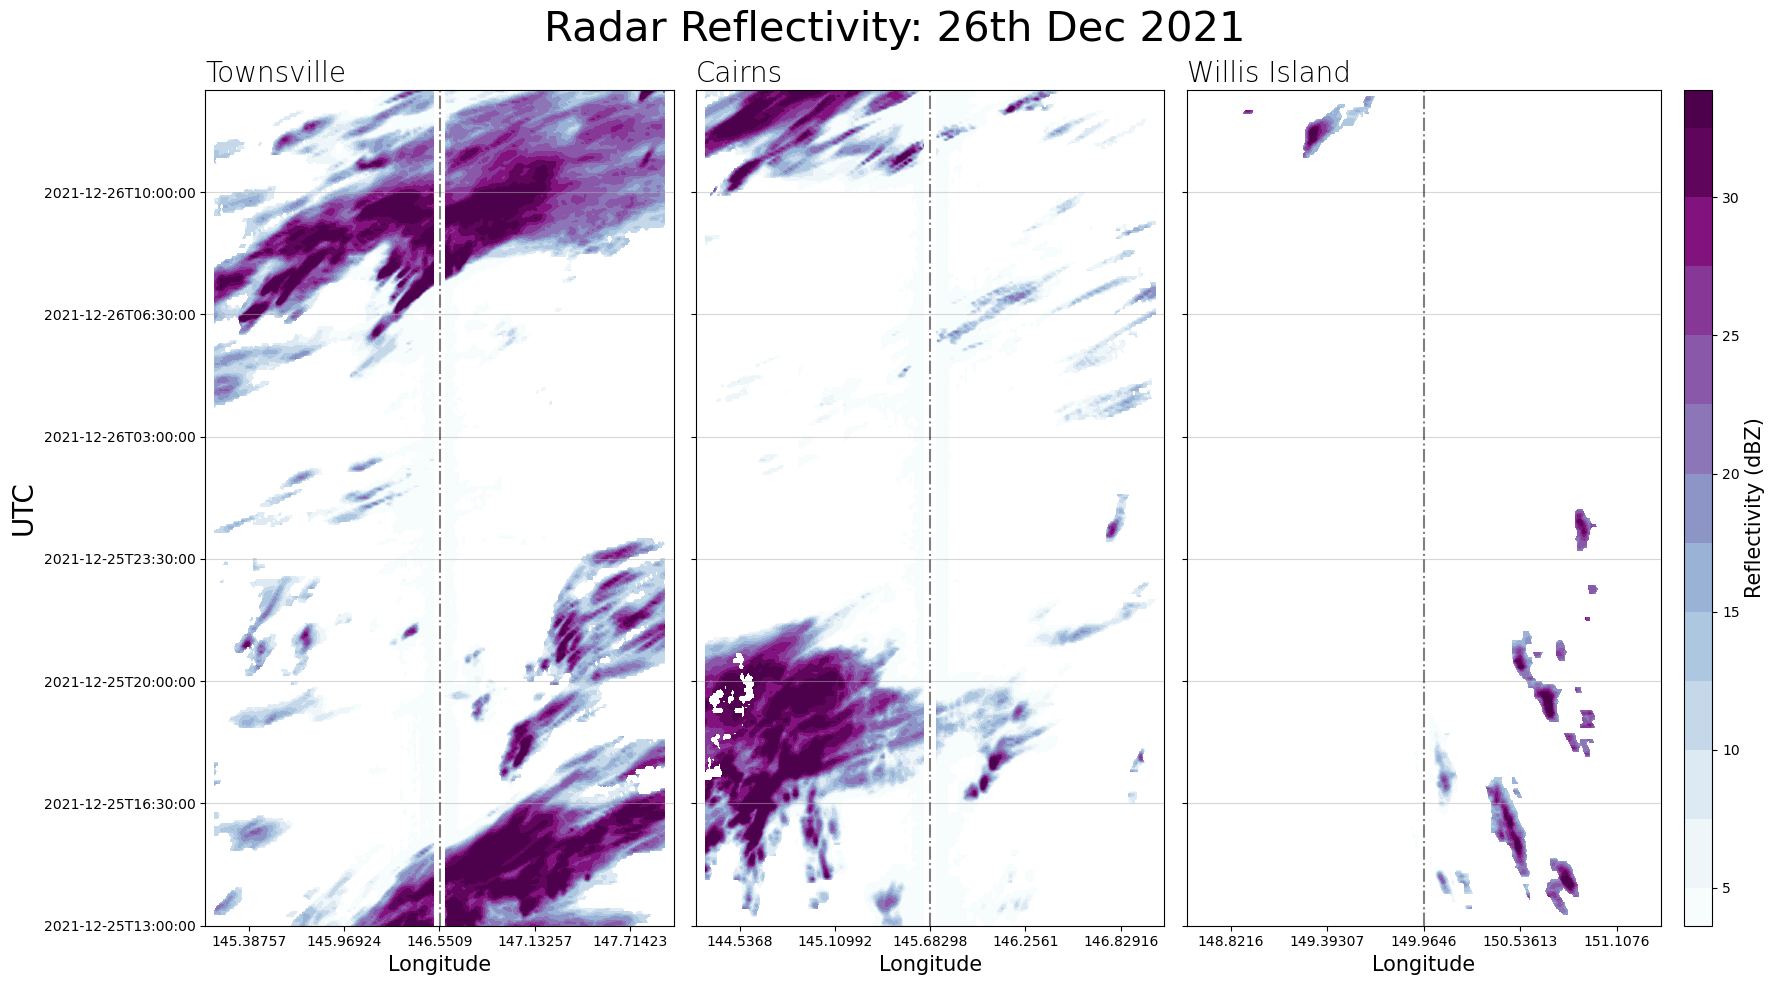

In [12]:
plot_hovmoller('2021-12-25T13:00:00.000000000','2021-12-26T12:55:00.000000000',7,"reflectivity",
               "Radar Reflectivity: 26th Dec 2021",
               [5,7.5,10,12.5,15,17.5,20,22.5,25,27.5,30,32.5],"BuPu","Reflectivity (dBZ)",anomaly=False)

# Radar Hovmoller plots for 8 day period (case study)

In [3]:
files_T = ["/g/data/rq0/level_2/73/REFLECTIVITY/73_20220208_reflectivity.nc",
           "/g/data/rq0/level_2/73/REFLECTIVITY/73_20220209_reflectivity.nc",
           "/g/data/rq0/level_2/73/REFLECTIVITY/73_20220210_reflectivity.nc",
           "/g/data/rq0/level_2/73/REFLECTIVITY/73_20220211_reflectivity.nc",
           "/g/data/rq0/level_2/73/REFLECTIVITY/73_20220212_reflectivity.nc",
           "/g/data/rq0/level_2/73/REFLECTIVITY/73_20220213_reflectivity.nc",
           "/g/data/rq0/level_2/73/REFLECTIVITY/73_20220214_reflectivity.nc",
           "/g/data/rq0/level_2/73/REFLECTIVITY/73_20220215_reflectivity.nc"]
print('files Townsville: ',files_T)

files_C = ["/g/data/rq0/level_2/19/REFLECTIVITY/19_20220208_reflectivity.nc",
           "/g/data/rq0/level_2/19/REFLECTIVITY/19_20220209_reflectivity.nc",
           "/g/data/rq0/level_2/19/REFLECTIVITY/19_20220210_reflectivity.nc",
           "/g/data/rq0/level_2/19/REFLECTIVITY/19_20220211_reflectivity.nc",
           "/g/data/rq0/level_2/19/REFLECTIVITY/19_20220212_reflectivity.nc",
           "/g/data/rq0/level_2/19/REFLECTIVITY/19_20220213_reflectivity.nc",
           "/g/data/rq0/level_2/19/REFLECTIVITY/19_20220214_reflectivity.nc",
           "/g/data/rq0/level_2/19/REFLECTIVITY/19_20220215_reflectivity.nc"]
print('files Cairns: ',files_C)

files_W = ["/g/data/rq0/level_2/41/REFLECTIVITY/41_20220208_reflectivity.nc",
           "/g/data/rq0/level_2/41/REFLECTIVITY/41_20220209_reflectivity.nc",
           "/g/data/rq0/level_2/41/REFLECTIVITY/41_20220210_reflectivity.nc",
           "/g/data/rq0/level_2/41/REFLECTIVITY/41_20220211_reflectivity.nc",
           "/g/data/rq0/level_2/41/REFLECTIVITY/41_20220212_reflectivity.nc",
           "/g/data/rq0/level_2/41/REFLECTIVITY/41_20220213_reflectivity.nc",
           "/g/data/rq0/level_2/41/REFLECTIVITY/41_20220214_reflectivity.nc",
           "/g/data/rq0/level_2/41/REFLECTIVITY/41_20220215_reflectivity.nc"]
print('files Willis Island: ',files_W)

# open datasets
ds_T = xr.open_mfdataset(files_T, engine="netcdf4")
ds_C = xr.open_mfdataset(files_C, engine="netcdf4")
ds_W = xr.open_mfdataset(files_W, engine="netcdf4")

files Townsville:  ['/g/data/rq0/level_2/73/REFLECTIVITY/73_20220208_reflectivity.nc', '/g/data/rq0/level_2/73/REFLECTIVITY/73_20220209_reflectivity.nc', '/g/data/rq0/level_2/73/REFLECTIVITY/73_20220210_reflectivity.nc', '/g/data/rq0/level_2/73/REFLECTIVITY/73_20220211_reflectivity.nc', '/g/data/rq0/level_2/73/REFLECTIVITY/73_20220212_reflectivity.nc', '/g/data/rq0/level_2/73/REFLECTIVITY/73_20220213_reflectivity.nc', '/g/data/rq0/level_2/73/REFLECTIVITY/73_20220214_reflectivity.nc', '/g/data/rq0/level_2/73/REFLECTIVITY/73_20220215_reflectivity.nc']
files Cairns:  ['/g/data/rq0/level_2/19/REFLECTIVITY/19_20220208_reflectivity.nc', '/g/data/rq0/level_2/19/REFLECTIVITY/19_20220209_reflectivity.nc', '/g/data/rq0/level_2/19/REFLECTIVITY/19_20220210_reflectivity.nc', '/g/data/rq0/level_2/19/REFLECTIVITY/19_20220211_reflectivity.nc', '/g/data/rq0/level_2/19/REFLECTIVITY/19_20220212_reflectivity.nc', '/g/data/rq0/level_2/19/REFLECTIVITY/19_20220213_reflectivity.nc', '/g/data/rq0/level_2/19/RE

In [4]:
lat_T = ds_T["latitude"].isel(y=150,time=0) 
lat_C = ds_C["latitude"].isel(y=150,time=0) 
lat_W = ds_W["latitude"].isel(y=150,time=0)
lon_T = ds_T.longitude
lon_C = ds_C.longitude
lon_W = ds_W.longitude
start_time = '2022-02-08T00:00:00.000000000'
end_time = '2022-02-15T23:55:00.000000000'
time_slice = slice(start_time, end_time)
variable_data_T = ds_T["reflectivity"].isel(y=150).sel(time=time_slice)
variable_data_T
ds_W.latitude.isel(y=150,time=0).values

array([-16.282776, -16.282837, -16.282898, -16.282959, -16.28302 ,
       -16.283081, -16.283142, -16.283203, -16.283264, -16.283325,
       -16.283386, -16.283386, -16.283447, -16.283508, -16.28357 ,
       -16.28363 , -16.283691, -16.283752, -16.283813, -16.283875,
       -16.283936, -16.283997, -16.283997, -16.284058, -16.284119,
       -16.28418 , -16.28424 , -16.284302, -16.284302, -16.284363,
       -16.284424, -16.284485, -16.284546, -16.284607, -16.284607,
       -16.284668, -16.284729, -16.28479 , -16.28479 , -16.284851,
       -16.284912, -16.284973, -16.284973, -16.285034, -16.285095,
       -16.285156, -16.285156, -16.285217, -16.285278, -16.285278,
       -16.28534 , -16.2854  , -16.2854  , -16.285461, -16.285522,
       -16.285522, -16.285583, -16.285645, -16.285645, -16.285706,
       -16.285706, -16.285767, -16.285828, -16.285828, -16.285889,
       -16.285889, -16.28595 , -16.28595 , -16.28601 , -16.286072,
       -16.286072, -16.286133, -16.286133, -16.286194, -16.286

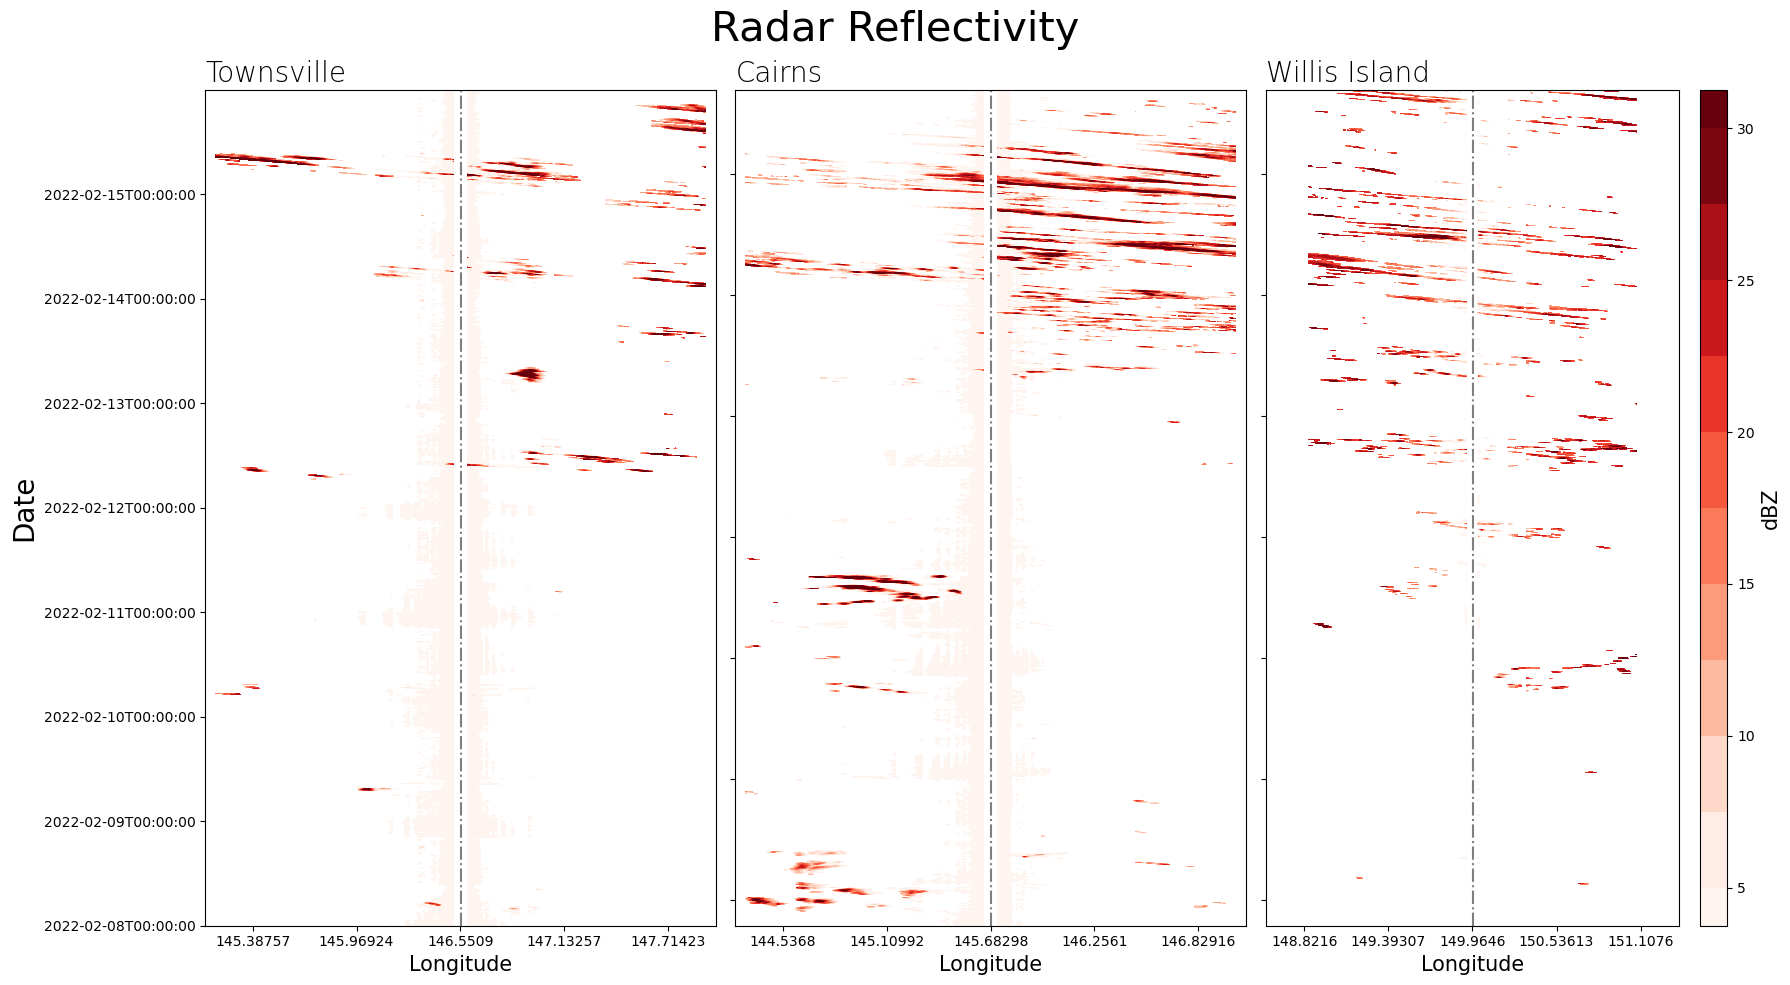

In [9]:
plot_hovmoller('2022-02-08T00:00:00.000000000','2022-02-15T23:55:00.000000000',8,"reflectivity","Radar Reflectivity",
               [5,7.5,10,12.5,15,17.5,20,22.5,25,27.5,30],"Reds","dBZ",anomaly=False)

In [10]:
plot_hovmoller('2022-02-08T00:00:00.000000000','2022-02-15T23:55:00.000000000',8,"reflectivity","Radar Reflectivity Anomaly",
               [-4,-2,0,2,4,6,8,10,12,14,16,18,20],"Reds","dBZ",anomaly=True)

AttributeError: 'DataArray' object has no attribute 'time'

# Plot for 13th, 14th & 15th

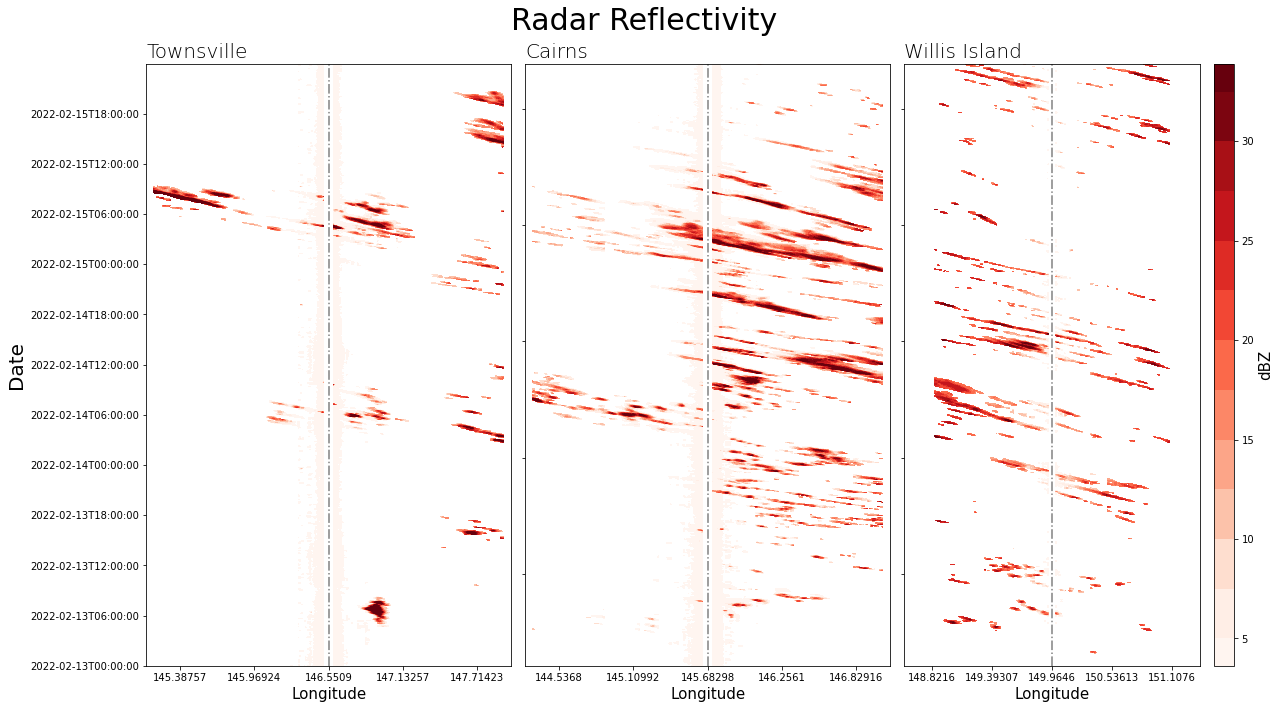

In [9]:
plot_hovmoller('2022-02-13T00:00:00.000000000','2022-02-15T23:55:00.000000000',12,"reflectivity","Radar Reflectivity",
               [5,7.5,10,12.5,15,17.5,20,22.5,25,27.5,30,32.5],"Reds","dBZ",anomaly=False)

# Plot Radar & BARRA-2

In [18]:
# reading for case study
variable = "av_wnd_ucmp_uv"
files_av_wnd_ucmp_uv = [
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0000Z/"+variable+"-barra_r2-hres-202202080300-202202080900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0600Z/"+variable+"-barra_r2-hres-202202080900-202202081500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1200Z/"+variable+"-barra_r2-hres-202202081500-202202082100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1800Z/"+variable+"-barra_r2-hres-202202082100-202202090300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0000Z/"+variable+"-barra_r2-hres-202202090300-202202090900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0600Z/"+variable+"-barra_r2-hres-202202090900-202202091500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1200Z/"+variable+"-barra_r2-hres-202202091500-202202092100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1800Z/"+variable+"-barra_r2-hres-202202092100-202202100300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0000Z/"+variable+"-barra_r2-hres-202202100300-202202100900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0600Z/"+variable+"-barra_r2-hres-202202100900-202202101500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1200Z/"+variable+"-barra_r2-hres-202202101500-202202102100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1800Z/"+variable+"-barra_r2-hres-202202102100-202202110300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0000Z/"+variable+"-barra_r2-hres-202202110300-202202110900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0600Z/"+variable+"-barra_r2-hres-202202110900-202202111500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1200Z/"+variable+"-barra_r2-hres-202202111500-202202112100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1800Z/"+variable+"-barra_r2-hres-202202112100-202202120300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0000Z/"+variable+"-barra_r2-hres-202202120300-202202120900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0600Z/"+variable+"-barra_r2-hres-202202120900-202202121500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1200Z/"+variable+"-barra_r2-hres-202202121500-202202122100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1800Z/"+variable+"-barra_r2-hres-202202122100-202202130300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0000Z/"+variable+"-barra_r2-hres-202202130300-202202130900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0600Z/"+variable+"-barra_r2-hres-202202130900-202202131500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1200Z/"+variable+"-barra_r2-hres-202202131500-202202132100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1800Z/"+variable+"-barra_r2-hres-202202132100-202202140300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0000Z/"+variable+"-barra_r2-hres-202202140300-202202140900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0600Z/"+variable+"-barra_r2-hres-202202140900-202202141500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1200Z/"+variable+"-barra_r2-hres-202202141500-202202142100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1800Z/"+variable+"-barra_r2-hres-202202142100-202202150300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0000Z/"+variable+"-barra_r2-hres-202202150300-202202150900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0600Z/"+variable+"-barra_r2-hres-202202150900-202202151500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1200Z/"+variable+"-barra_r2-hres-202202151500-202202152100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1800Z/"+variable+"-barra_r2-hres-202202152100-202202160300.nc",
]
barra2_ds = xr.open_mfdataset(files_av_wnd_ucmp_uv, engine="netcdf4")

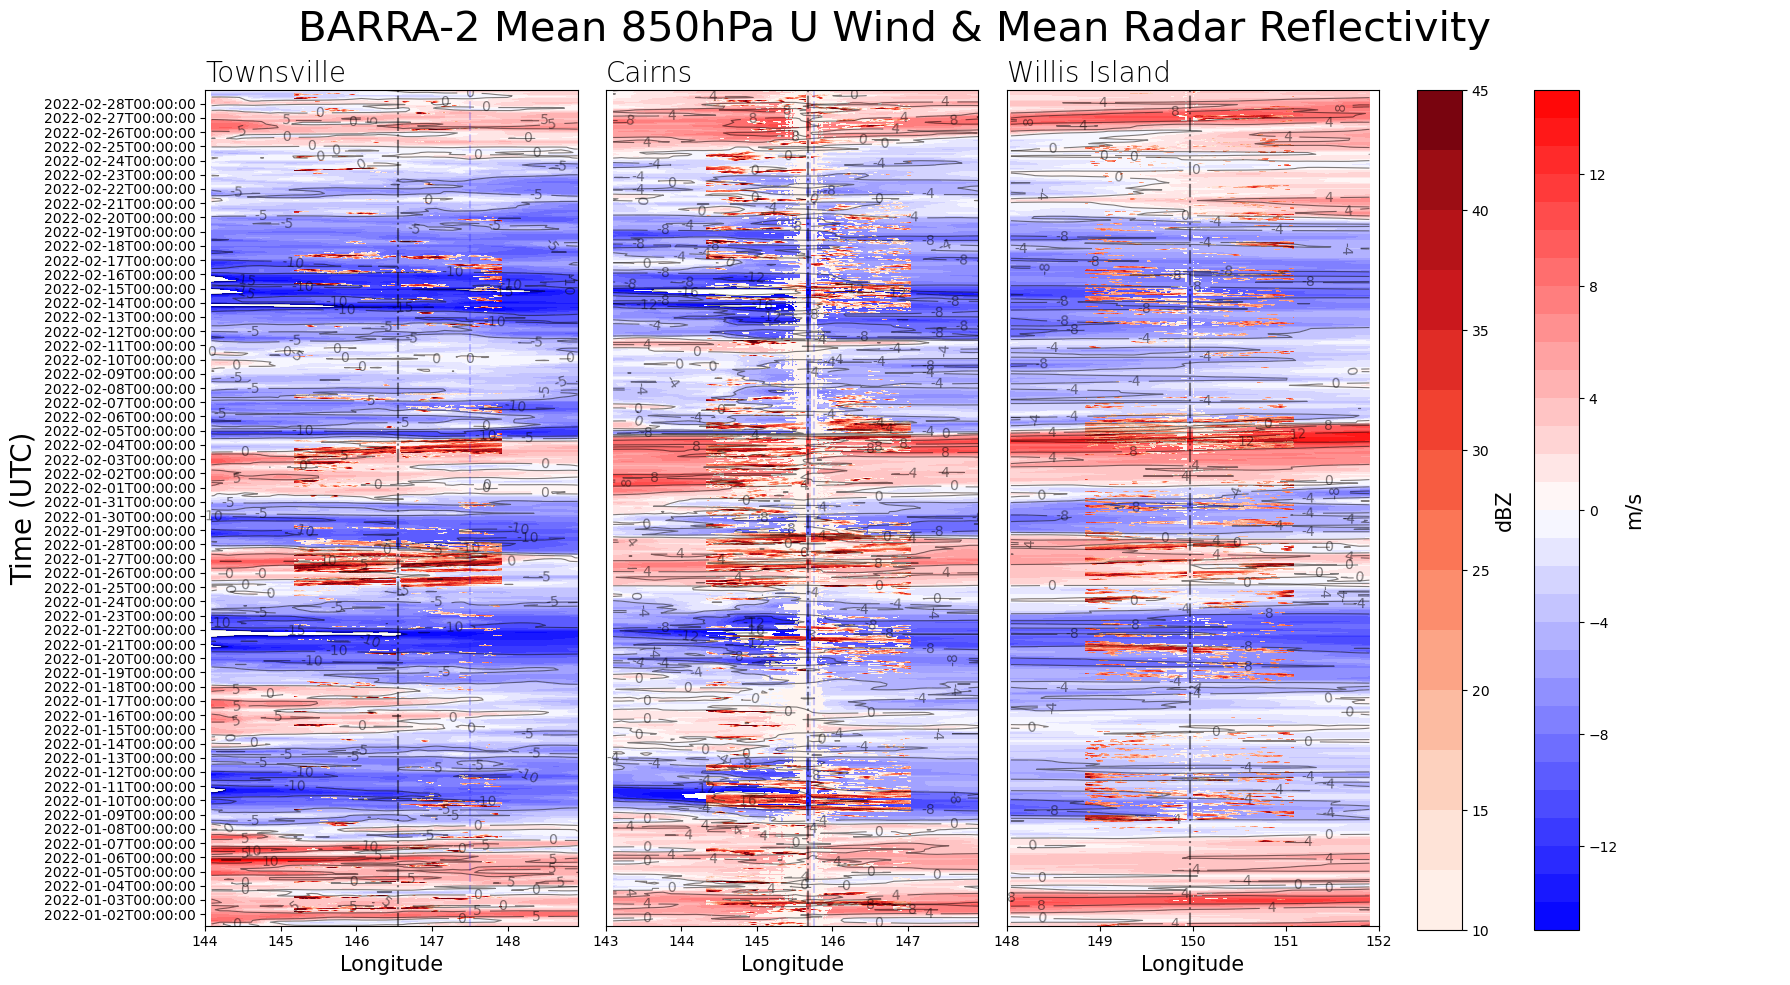

In [42]:
# BARRA-2 ############
start_time = '2022-01-01T00:00:00.000000000'
end_time = '2022-02-28T23:55:00.000000000'
time_slice_barra = slice(start_time, end_time)
lat_C = -16.830002 # -16.817
lat_W = -16.279999 # -16.2874
lon_slice_T = slice(144, 149)                  
lon_slice_C = slice(143,148)
lon_slice_W = slice(148,152)
# Get data, selecting time, lat/lon slice
variable_data_T_barra = barra2_ds["av_wnd_ucmp_uv"].isel(latitude=361).sel(longitude=lon_slice_T,time=time_slice_barra,pressure=850) 
variable_data_C_barra = barra2_ds["av_wnd_ucmp_uv"].isel(latitude=385).sel(longitude=lon_slice_C,time=time_slice_barra,pressure=850) 
variable_data_W_barra = barra2_ds["av_wnd_ucmp_uv"].isel(latitude=390).sel(longitude=lon_slice_W,time=time_slice_barra,pressure=850) 
# Get times and make array of datetime objects
variable_times_T_barra = variable_data_T_barra.time.values.astype('datetime64[ns]').astype('O')
variable_times_C_barra = variable_data_C_barra.time.values.astype('datetime64[ns]').astype('O')
variable_times_W_barra = variable_data_W_barra.time.values.astype('datetime64[ns]').astype('O')
# Specify longitude values for chosen domain
lons_T_barra = variable_data_T_barra.longitude.values
lons_C_barra = variable_data_C_barra.longitude.values
lons_W_barra = variable_data_W_barra.longitude.values 

# Radar #############
start = '2022-01-01T00:00:00.000000000'
end = '2022-02-28T23:55:00.000000000'
time_slice_radar = slice(start, end)
variable_data_T_radar = ds_T["reflectivity"].isel(y=150).sel(time=time_slice_radar)
variable_data_C_radar = ds_C["reflectivity"].isel(y=150).sel(time=time_slice_radar)
variable_data_W_radar = ds_W["reflectivity"].isel(y=150).sel(time=time_slice_radar)
# Get times and make array of datetime objects
variable_times_T_radar = variable_data_T_radar.time.values.astype('datetime64[ns]').astype('O')
variable_times_C_radar = variable_data_C_radar.time.values.astype('datetime64[ns]').astype('O')
variable_times_W_radar = variable_data_W_radar.time.values.astype('datetime64[ns]').astype('O')
# Specify longitude values for chosen domain
lons_T_radar = ds_T["longitude"].isel(y=150,time=0).values #variable_data_T_radar.x.values
lons_C_radar = ds_C["longitude"].isel(y=150,time=0).values
lons_W_radar = ds_W["longitude"].isel(y=150,time=0).values

# make plot ###########
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(18,10))#,gridspec_kw={'width_ratios': [4, 4,5]})
fig.patch.set_facecolor('white')

# Set some titles
axes[0].set_title('Townsville', loc='left', fontsize=20,fontweight=0.9)
axes[1].set_title('Cairns', loc='left', fontsize=20,fontweight=0.9)
axes[2].set_title('Willis Island', loc='left', fontsize=20,fontweight=0.9)
fig.figure.suptitle("BARRA-2 Mean 850hPa U Wind & Mean Radar Reflectivity",fontsize=30) #,x=0.2,y=0.98,
axes[-1].axis('off')
fig.subplots_adjust(right=0.85)

# Plot of chosen variable averaged over latitude and slightly smoothed
levels = [-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
levels1 = [10,12.5,15,17.5,20,22.5,25,27.5,30,32.5,35,37.5,40,42.5,45]
# Townsville: axis 0
axes[0].contourf(lons_T_barra, variable_times_T_barra, variable_data_T_barra, levels=levels, cmap="bwr")
cf_T_radar = axes[0].contourf(lons_T_radar, variable_times_T_radar, variable_data_T_radar, levels=levels1, cmap="Reds")
# Cairns: axis 1
axes[1].contourf(lons_C_barra, variable_times_C_barra, variable_data_C_barra, levels=levels, cmap="bwr");
axes[1].contourf(lons_C_radar, variable_times_C_radar, variable_data_C_radar, levels=levels1, cmap="Reds", extend='both')
# Willis Island: axis 2
cf_W_barra = axes[2].contourf(lons_W_barra, variable_times_W_barra, variable_data_W_barra, levels=levels, cmap="bwr");
axes[2].contourf(lons_W_radar, variable_times_W_radar, variable_data_W_radar, levels=levels1, cmap="Reds", extend='both')               
# plot wind speed contour lines                    
line_colors = ['black' for l in cf_W_barra.levels]
cs_T = axes[0].contour(lons_T_barra, variable_times_T_barra, variable_data_T_barra, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_C = axes[1].contour(lons_C_barra, variable_times_C_barra, variable_data_C_barra, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_W = axes[2].contour(lons_W_barra, variable_times_W_barra, variable_data_W_barra, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
# plot contour line labels
plt.clabel(cs_T, fontsize=10, inline=1,fmt = '%1.0f')
plt.clabel(cs_C, fontsize=10, inline=1,fmt = '%1.0f')
plt.clabel(cs_W, fontsize=10, inline=1,fmt = '%1.0f')

# plot cbar and cbar label 
cbar_ax = fig.add_axes([0.855,0.06,0.025,0.84])
cbar_ax1 = fig.add_axes([0.79, 0.06, 0.025, 0.84])
cbar_W_barra = fig.colorbar(cf_W_barra, cax=cbar_ax,pad=0.04, aspect=30)
cbar_W_radar = fig.colorbar(cf_T_radar, cax=cbar_ax1,pad=0.04, aspect=30)
    #cbar_W_barra = plt.colorbar(cf_W_barra, ax=axes[3],orientation='vertical', pad=0.04, aspect=30)
cbar_W_barra.set_label("m/s",fontsize=15)    
    #cbar_W_radar = plt.colorbar(cf_T_radar, ax=axes[3],orientation='vertical', pad=0, aspect=30)
cbar_W_radar.set_label("dBZ",fontsize=15)
   
# plot vertical lines to represent coastlines
axes[0].axvline(147.5,color='blue',alpha=0.2,linestyle='--')
axes[1].axvline(145.75,color='blue',alpha=0.2,linestyle='--')
    
# plot locations of radars
axes[0].axvline(146.5509,color='k',alpha=0.5,linestyle='-.')
axes[1].axvline(145.683,color='k',alpha=0.5,linestyle='-.')
axes[2].axvline(149.9646,color='k',alpha=0.5,linestyle='-.')
    
# Make some ticks and tick labels
xticks_T = np.arange(144,149,1)
xticks_C = np.arange(143,148,1)
xticks_W = np.arange(148,153,1)            
axes[0].set_xticks(xticks_T)
axes[1].set_xticks(xticks_C)
axes[2].set_xticks(xticks_W)
                    
x_tick_labels_T = ["144","145","146","147","148"]
x_tick_labels_C = ["143","144","145","146","147"]
x_tick_labels_W = ["148","149","150","151","152"]        
axes[0].set_xticklabels(x_tick_labels_T)
axes[1].set_xticklabels(x_tick_labels_C)
axes[2].set_xticklabels(x_tick_labels_W)
    
axes[0].set_yticks(variable_times_T_radar)
axes[1].set_yticks([])
axes[2].set_yticks([])
axes[0].locator_params(axis='y', nbins=59)
# datetime64[ns] = nano-second precision
# datetime64[s] = second precision; datetime64[D] = date precision
axes[0].set_yticklabels(variable_data_T_radar.time.values.astype('datetime64[s]'))
axes[1].set(yticklabels=[]) 
axes[2].set(yticklabels=[]) 
                    
axes[0].set_xlabel("Longitude",fontsize=15)
axes[1].set_xlabel("Longitude",fontsize=15)
axes[2].set_xlabel("Longitude",fontsize=15)
axes[0].set_ylabel("Time (UTC)",fontsize=20)            
                    
fig.tight_layout()
plt.show();

# smaller domain

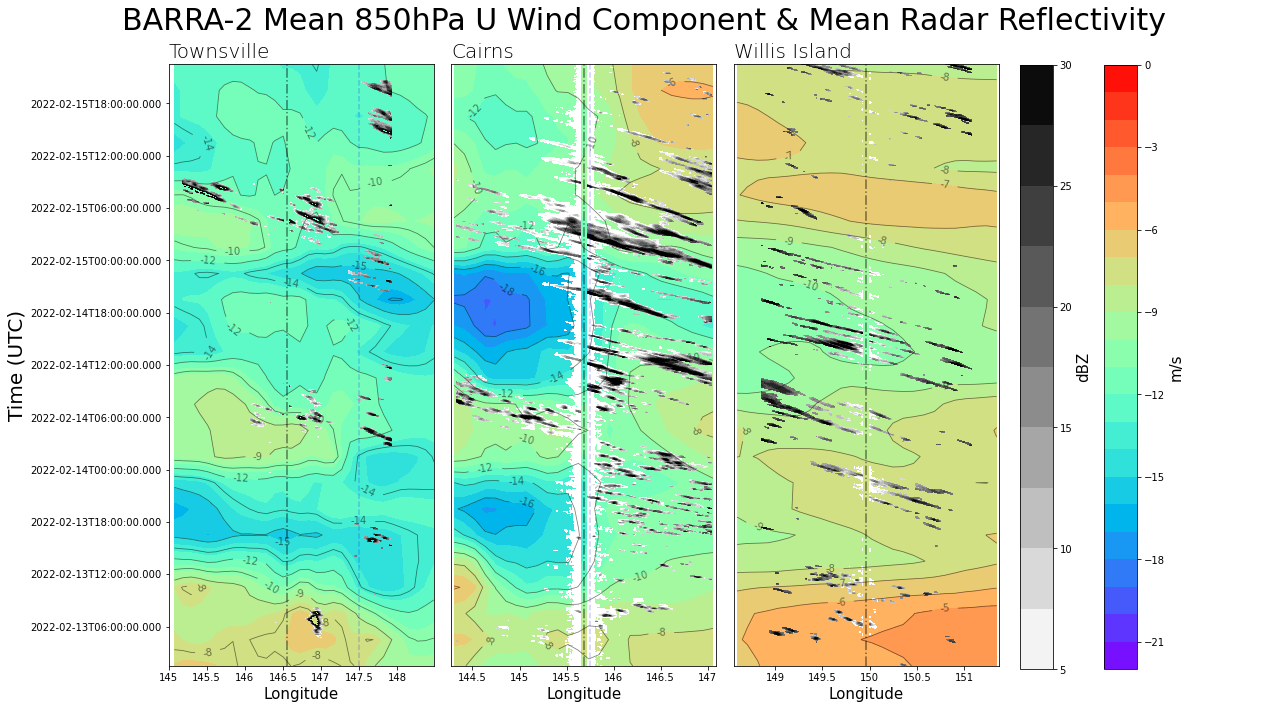

In [28]:
start_time = '2022-02-13T00:00:00.000000000'
end_time = '2022-02-16T00:00:00.000000000'
time_slice_barra = slice(start_time, end_time)
lat_C = -16.830002 # -16.817
lat_W = -16.279999 # -16.2874
lon_slice_T = slice(145, 148.5)                  
lon_slice_C = slice(144.27374, 147.09222)
lon_slice_W = slice(148.55927,151.36993)

# Get data, selecting time, lat/lon slice
variable_data_T_barra = barra2_ds["av_wnd_ucmp_uv"].isel(latitude=361).sel(longitude=lon_slice_T,time=time_slice_barra,pressure=850) 
variable_data_C_barra = barra2_ds["av_wnd_ucmp_uv"].isel(latitude=385).sel(longitude=lon_slice_C,time=time_slice_barra,pressure=850) 
variable_data_W_barra = barra2_ds["av_wnd_ucmp_uv"].isel(latitude=390).sel(longitude=lon_slice_W,time=time_slice_barra,pressure=850) 
# Get times and make array of datetime objects
variable_times_T_barra = variable_data_T_barra.time.values.astype('datetime64[ns]').astype('O')
variable_times_C_barra = variable_data_C_barra.time.values.astype('datetime64[ns]').astype('O')
variable_times_W_barra = variable_data_W_barra.time.values.astype('datetime64[ns]').astype('O')
# Specify longitude values for chosen domain
lons_T_barra = variable_data_T_barra.longitude.values
lons_C_barra = variable_data_C_barra.longitude.values
lons_W_barra = variable_data_W_barra.longitude.values 

# radar
start = '2022-02-13T00:00:00.000000000'
end = '2022-02-15T23:55:00.000000000'
time_slice_radar = slice(start, end)
variable_data_T_radar = ds_T["reflectivity"].isel(y=150).sel(time=time_slice_radar)
variable_data_C_radar = ds_C["reflectivity"].isel(y=150).sel(time=time_slice_radar)
variable_data_W_radar = ds_W["reflectivity"].isel(y=150).sel(time=time_slice_radar)
# Get times and make array of datetime objects
variable_times_T_radar = variable_data_T_radar.time.values.astype('datetime64[ns]').astype('O')
variable_times_C_radar = variable_data_C_radar.time.values.astype('datetime64[ns]').astype('O')
variable_times_W_radar = variable_data_W_radar.time.values.astype('datetime64[ns]').astype('O')
# Specify longitude values for chosen domain
lons_T_radar = ds_T["longitude"].isel(y=150,time=0).values #variable_data_T_radar.x.values
lons_C_radar = ds_C["longitude"].isel(y=150,time=0).values
lons_W_radar = ds_W["longitude"].isel(y=150,time=0).values

# make plot
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(18,10))
fig.patch.set_facecolor('white')

# Set some titles
axes[0].set_title('Townsville', loc='left', fontsize=20,fontweight=0.9)
axes[1].set_title('Cairns', loc='left', fontsize=20,fontweight=0.9)
axes[2].set_title('Willis Island', loc='left', fontsize=20,fontweight=0.9)
fig.figure.suptitle("BARRA-2 Mean 850hPa U Wind Component & Mean Radar Reflectivity",fontsize=30) #,x=0.2,y=0.98,
axes[-1].axis('off')
fig.subplots_adjust(right=0.85)

# cmap
#orig_map =plt.cm.get_cmap('Blues')
#rev_map = orig_map.reversed()

# Plot of chosen variable averaged over latitude and slightly smoothed
levels = [-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0]
levels1 = [5,7.5,10,12.5,15,17.5,20,22.5,25,27.5,30]
# axis 0
axes[0].contourf(lons_T_barra, variable_times_T_barra, variable_data_T_barra, levels=levels, cmap="rainbow")
cf_T_radar = axes[0].contourf(lons_T_radar, variable_times_T_radar, variable_data_T_radar, levels=levels1, cmap="binary")
# axis 1
axes[1].contourf(lons_C_barra, variable_times_C_barra, variable_data_C_barra, levels=levels, cmap="rainbow");
axes[1].contourf(lons_C_radar, variable_times_C_radar, variable_data_C_radar, levels=levels1, cmap="binary", extend='both')
# axis 2
cf_W_barra = axes[2].contourf(lons_W_barra, variable_times_W_barra, variable_data_W_barra, levels=levels, cmap="rainbow");
axes[2].contourf(lons_W_radar, variable_times_W_radar, variable_data_W_radar, levels=levels1, cmap="binary", extend='both')               

# plot wind speed contour lines                    
line_colors = ['black' for l in cf_W_barra.levels]
cs_T = axes[0].contour(lons_T_barra, variable_times_T_barra, variable_data_T_barra, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_C = axes[1].contour(lons_C_barra, variable_times_C_barra, variable_data_C_barra, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
cs_W = axes[2].contour(lons_W_barra, variable_times_W_barra, variable_data_W_barra, alpha=0.5,colors=line_colors, linewidths=0.8,linestyles='-')
# plot contour line labels
plt.clabel(cs_T, fontsize=10, inline=1,fmt = '%1.0f')
plt.clabel(cs_C, fontsize=10, inline=1,fmt = '%1.0f')
plt.clabel(cs_W, fontsize=10, inline=1,fmt = '%1.0f')

# cbar and cbar label 
cbar_ax = fig.add_axes([0.855,0.06,0.025,0.84])
cbar_ax1 = fig.add_axes([0.79, 0.06, 0.025, 0.84])
cbar_W_barra = fig.colorbar(cf_W_barra, cax=cbar_ax,pad=0.04, aspect=30)
cbar_W_radar = fig.colorbar(cf_T_radar, cax=cbar_ax1,pad=0.04, aspect=30)
#cbar_W_barra = plt.colorbar(cf_W_barra, ax=axes[3],orientation='vertical', pad=0.04, aspect=30)
cbar_W_barra.set_label("m/s",fontsize=15)    
#cbar_W_radar = plt.colorbar(cf_T_radar, ax=axes[3],orientation='vertical', pad=0, aspect=30)
cbar_W_radar.set_label("dBZ",fontsize=15)
   
# plot vertical lines to represent coastlines
axes[0].axvline(147.5,color='blue',alpha=0.2,linestyle='--')
axes[1].axvline(145.75,color='blue',alpha=0.2,linestyle='--')
    
# plot locations of radars
axes[0].axvline(146.5509,color='k',alpha=0.5,linestyle='-.')
axes[1].axvline(145.683,color='k',alpha=0.5,linestyle='-.')
axes[2].axvline(149.9646,color='k',alpha=0.5,linestyle='-.')
    
# Make some ticks and tick labels
xticks_T = np.arange(145,148.5,0.5)
xticks_C = np.arange(144.5,147.5,0.5)
xticks_W = np.arange(149,151.5,0.5)            
axes[0].set_xticks(xticks_T)
axes[1].set_xticks(xticks_C)
axes[2].set_xticks(xticks_W)
                    
x_tick_labels_T = ["145","145.5","146","146.5","147","147.5","148"]
x_tick_labels_C = ["144.5","145","145.5","146","146.5","147"]
x_tick_labels_W = ["149","149.5","150","150.5","151"]        
axes[0].set_xticklabels(x_tick_labels_T)
axes[1].set_xticklabels(x_tick_labels_C)
axes[2].set_xticklabels(x_tick_labels_W)
    
axes[0].set_yticks(variable_times_T_radar)
axes[1].set_yticks([])
axes[2].set_yticks([])
axes[0].locator_params(axis='y', nbins=12)
axes[0].set_yticklabels(variable_data_T_radar.time.values.astype('datetime64[ms]'))
axes[1].set(yticklabels=[]) 
axes[2].set(yticklabels=[]) 
                    
axes[0].set_xlabel("Longitude",fontsize=15)
axes[1].set_xlabel("Longitude",fontsize=15)
axes[2].set_xlabel("Longitude",fontsize=15)
axes[0].set_ylabel("Time (UTC)",fontsize=20)            
                    
fig.tight_layout()
plt.show();

# barra-2 winds at other pressure levels (not surface) - hourly resolution

In [16]:
variable = "wnd_ucmp"
files_wnd_ucmp = [
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0000Z/"+variable+"-barra_r2-hres-202202080300-202202080900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T0600Z/"+variable+"-barra_r2-hres-202202080900-202202081500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1200Z/"+variable+"-barra_r2-hres-202202081500-202202082100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220208T1800Z/"+variable+"-barra_r2-hres-202202082100-202202090300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0000Z/"+variable+"-barra_r2-hres-202202090300-202202090900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T0600Z/"+variable+"-barra_r2-hres-202202090900-202202091500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1200Z/"+variable+"-barra_r2-hres-202202091500-202202092100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220209T1800Z/"+variable+"-barra_r2-hres-202202092100-202202100300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0000Z/"+variable+"-barra_r2-hres-202202100300-202202100900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T0600Z/"+variable+"-barra_r2-hres-202202100900-202202101500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1200Z/"+variable+"-barra_r2-hres-202202101500-202202102100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220210T1800Z/"+variable+"-barra_r2-hres-202202102100-202202110300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0000Z/"+variable+"-barra_r2-hres-202202110300-202202110900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T0600Z/"+variable+"-barra_r2-hres-202202110900-202202111500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1200Z/"+variable+"-barra_r2-hres-202202111500-202202112100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220211T1800Z/"+variable+"-barra_r2-hres-202202112100-202202120300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0000Z/"+variable+"-barra_r2-hres-202202120300-202202120900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T0600Z/"+variable+"-barra_r2-hres-202202120900-202202121500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1200Z/"+variable+"-barra_r2-hres-202202121500-202202122100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220212T1800Z/"+variable+"-barra_r2-hres-202202122100-202202130300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0000Z/"+variable+"-barra_r2-hres-202202130300-202202130900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T0600Z/"+variable+"-barra_r2-hres-202202130900-202202131500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1200Z/"+variable+"-barra_r2-hres-202202131500-202202132100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220213T1800Z/"+variable+"-barra_r2-hres-202202132100-202202140300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0000Z/"+variable+"-barra_r2-hres-202202140300-202202140900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T0600Z/"+variable+"-barra_r2-hres-202202140900-202202141500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1200Z/"+variable+"-barra_r2-hres-202202141500-202202142100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220214T1800Z/"+variable+"-barra_r2-hres-202202142100-202202150300.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0000Z/"+variable+"-barra_r2-hres-202202150300-202202150900.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T0600Z/"+variable+"-barra_r2-hres-202202150900-202202151500.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1200Z/"+variable+"-barra_r2-hres-202202151500-202202152100.nc",
    "/g/data/v46/yvh565/barra2/yhuang/20220215T1800Z/"+variable+"-barra_r2-hres-202202152100-202202160300.nc",
]